# Input Generation using Basal Ganglia Data

If you have done (input tuning)[../parallel/KTH_PDC/input_tuning] and saved the input settings to the neuron's meta.json files in BasalGangliaData then you can use that to set the appropriate level of your inputs.

If you need to tune the cortical and thalamic input for your own neurons, then see [this folder](../parallel/KTH_PDC/input_tuning/) which has examples and more information in the [README.md](../parallel/KTH_PDC/input_tuning/README.md) file.

In [1]:
import os
import numpy as np

network_path = os.path.join("networks","simple_example")
snudda_data = os.path.join("..", "..", "..", "BasalGangliaData", "data") 

## Generate the network

Here we create a network with 100 dSPN and 100 iSPN neurons. We also define two population units with 20 neurons each, by defining two spherical regions with radius 200 micrometers, and picking 20 neurons within those spheres).

The population units will be named 1 and 2.

In [2]:
from snudda import SnuddaInit

si = SnuddaInit(network_path=network_path, random_seed=12345, snudda_data=snudda_data)
si.define_striatum(num_dSPN=100, num_iSPN=100, num_FS=0, num_LTS=0, num_ChIN=0, neuron_density=80500,
                    volume_type="cube")

# Here we add two population units
# The centre of the cube is [0.00475, 0.004, 0.00775]. num_neurons is optional
si.add_population_unit_density(structure_name="Striatum", neuron_types=["dSPN", "iSPN"], 
                               unit_centre=np.array([0.00475, 0.004, 0.00775]) -np.array([0,50e-6,150e-6]),
                               probability_function="(d < 200e-6)*1", num_neurons=20)
si.add_population_unit_density(structure_name="Striatum", neuron_types=["dSPN", "iSPN"], 
                               unit_centre=np.array([0.00475, 0.004, 0.00775]) -np.array([150e-6,0,0]),
                               probability_function="(d < 200e-6) * 1", num_neurons=20)
si.write_json()

Using cube for striatum
Neurons for striatum read from /home/hjorth/HBP/BasalGangliaData/data/neurons/striatum
Adding neurons: dSPN from dir /home/hjorth/HBP/BasalGangliaData/data/neurons/striatum/dspn
Adding neurons: iSPN from dir /home/hjorth/HBP/BasalGangliaData/data/neurons/striatum/ispn
No directory $SNUDDA_DATA/neurons/striatum/ngf, skipping NGF cells.
Writing networks/simple_example/network-config.json


In [3]:
from snudda import SnuddaPlace
sp = SnuddaPlace(network_path=network_path)
sp.place()

from snudda import SnuddaDetect
sd = SnuddaDetect(network_path=network_path)
sd.detect()

from snudda import SnuddaPrune
sp = SnuddaPrune(network_path=network_path)
sp.prune()

Reading SNUDDA_DATA=../../../BasalGangliaData/data from networks/simple_example/network-config.json
Generating 1094 points for networks/simple_example/mesh/Striatum-cube-mesh-0.00013543930142996346.obj
n_points = 1042, previous close_pairs = 1589
n_points = 993, previous close_pairs = 1290
n_points = 947, previous close_pairs = 1062
n_points = 904, previous close_pairs = 878
n_points = 864, previous close_pairs = 715
n_points = 827, previous close_pairs = 598
n_points = 793, previous close_pairs = 498
n_points = 762, previous close_pairs = 406
n_points = 734, previous close_pairs = 345
n_points = 708, previous close_pairs = 296
n_points = 685, previous close_pairs = 249
n_points = 665, previous close_pairs = 206
n_points = 664, previous close_pairs = 168
n_points = 498, previous close_pairs = 166
Filtering 498 points..
Filtering, keeping inside points: 250 / 498
Reading SNUDDA_DATA=../../../BasalGangliaData/data from networks/simple_example/network-config.json
No d_view specified, runn

## Define input

The input tuning has set up four inputs for each neuron ```cortical_background```, ```thalamic_background```, ```cortical``` and ```thalamic```. The first two are background input at a low frequency (2Hz) which should bring the neurons to just below firing threshold. The last two inputs are by default set to 0Hz input frequency, but they are tuned so that when the input frequency is 10Hz the neurons should spike approximately at 40Hz. There are some variation depending on spike patterns and synapse location.

So what we want to do is modify the input frequency of the ```cortical``` input so that we get the spiking we want.

### ```input_config/basal-ganglia-data-input.json```

```
{
    "dSPN": {
        "cortical:1" : {
            "generator" : "poisson",
            "start" : [1, 4],
            "end" :   [3, 6],
            "frequency" : [5, 5],
            "populationUnitID" : 1
        },

        "cortical:2" : {
            "generator" : "poisson",
            "start" : [4],
            "end" :   [6],
            "frequency" : [10],
            "populationUnitID" : 2
        }       
    },


    "iSPN": {
        "cortical:1" : {
            "generator" : "poisson",
            "start" : [1, 4],
            "end" :   [3, 6],
            "frequency" : [5, 5],
            "populationUnitID" : 1          
        },

        "cortical:2" : {
            "generator" : "poisson",
            "start" : [4],
            "end" :   [6],
            "frequency" : [10],
            "populationUnitID" : 2
        }       
    }    
}
```

Here we can see that for the ```dSPN``` neurons we define two inputs: ```cortical:1``` and ```cortical:2``` that will be based on the ```cortical``` input. Everything after the ```:``` is ignored when finding a ```meta.json``` input to match with. The reason we don't simply call them both ```cortical``` is that each name has to be unique.

If we look in one of the ```meta.json``` files we can see (exerpt from the file), which will act as a template for our ```cortical:1``` input to the neurons:

```                "cortical": {
                    "generator": "poisson",
                    "type": "AMPA_NMDA",
                    "synapseDensity": "1.15*0.05/(1+exp(-(d-30e-6)/5e-6))",
                    "nInputs": 100,
                    "frequency": 0.0,
                    "populationUnitCorrelation": 0.0,
                    "jitter": 0.0,
                    "conductance": 5e-10,
                    "modFile": "tmGlut",
                    "parameterFile": "$DATA/synapses/striatum/M1RH_Analysis_190925.h5-parameters-MS.json"
                },
```

For a ```dSPN``` belonging to population unit 1 we will change the frequency to 5Hz. We will also add ```start``` and ```end``` times to the input.

In [4]:
import os
from snudda.input import SnuddaInput
si = SnuddaInput(network_path=network_path, 
                 input_config_file=os.path.join("input_config","basal-ganglia-data-input.json"),
                 verbose=False)
si.generate()

Reading SNUDDA_DATA=../../../BasalGangliaData/data from networks/simple_example/network-config.json
!!! Warning, combining definition of cortical with cortical:1 input for neuron iSPN_0 0 (meta modified by input_config)
!!! Warning, combining definition of cortical with cortical:2 input for neuron dSPN_2 2 (meta modified by input_config)
!!! Warning, combining definition of cortical with cortical:2 input for neuron dSPN_1 9 (meta modified by input_config)
!!! Warning, combining definition of cortical with cortical:2 input for neuron iSPN_3 11 (meta modified by input_config)
!!! Warning, combining definition of cortical with cortical:1 input for neuron iSPN_1 14 (meta modified by input_config)
!!! Warning, combining definition of cortical with cortical:2 input for neuron iSPN_1 15 (meta modified by input_config)
!!! Warning, combining definition of cortical with cortical:1 input for neuron dSPN_3 33 (meta modified by input_config)
!!! Warning, combining definition of cortical with corti

## Plotting the input

Let's look at the input for population unit 0 (ie. neurons not allocated to any population unit), and the two populations 1 and 2. Here we plot two neurons from each group.

In [5]:
from snudda.plotting import PlotInput
input_file = os.path.join(network_path, "input-spikes.hdf5")
spi = PlotInput(input_file)

### No population unit (id 0)

Here you can see that the two neurons (44) and (168) have both ```cortical_background``` and ```thalamic_background``` input, and that neuron 44 has many more synapses than neuron 168.

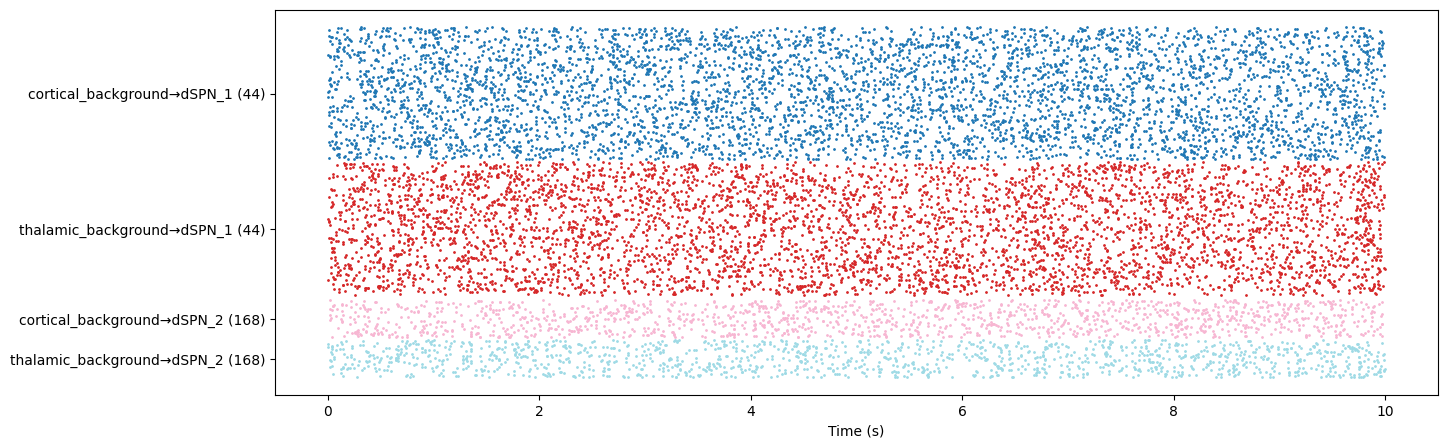

In [13]:
spi.plot_input_population_unit(population_unit_id=0, num_neurons=2, neuron_type="dSPN", fig_size=(15,5))

### Population unit 1

Here we see that the ```cortical``` inputs are active between 1 and 3, and 4 and 6 seconds. While the ```cortical_background``` and ```thalamic background``` are active throught the simulation.

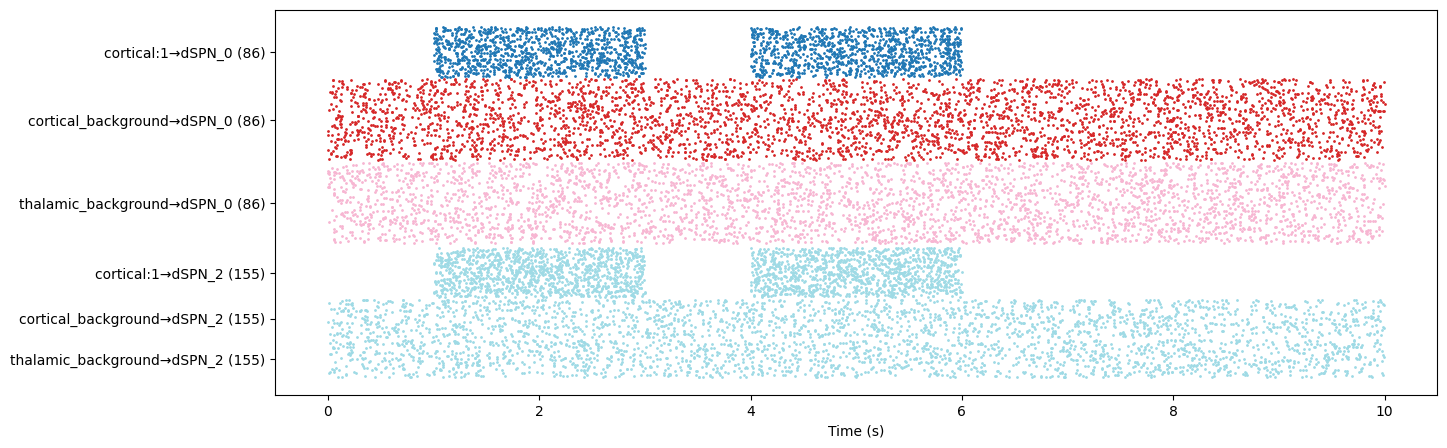

In [9]:
spi.plot_input_population_unit(population_unit_id=1, num_neurons=2, neuron_type="dSPN", fig_size=(15,5))

### Population unit 2

Here we see that the ```cortical``` inputs are active between 4 and 6 seconds. Again the ```cortical_background``` and ```thalamic background``` are active throught the simulation.

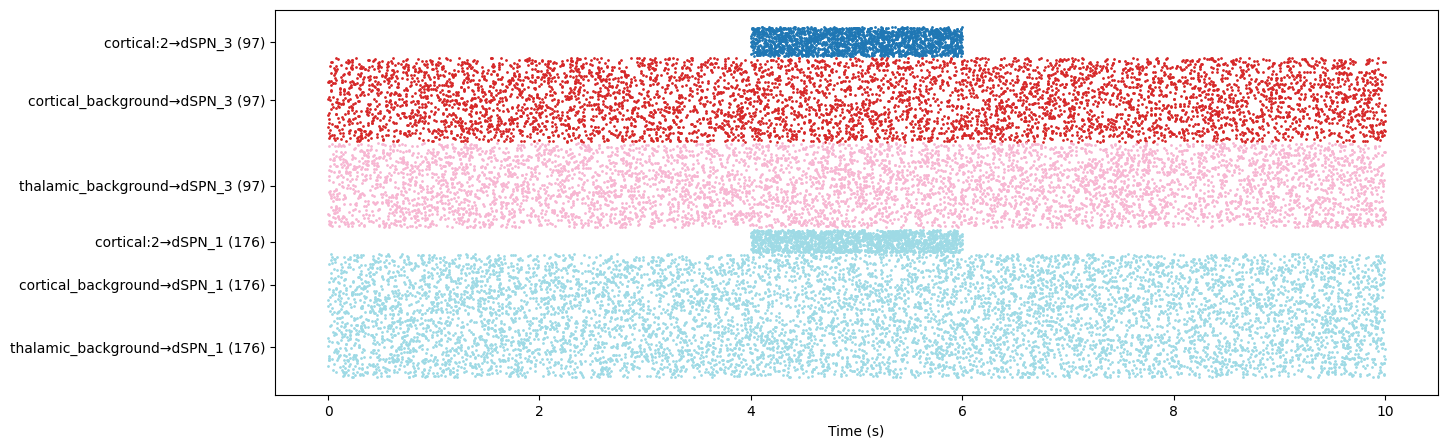

In [10]:
spi.plot_input_population_unit(population_unit_id=2, num_neurons=2, neuron_type="dSPN", fig_size=(15,5))

## Run the simulation:

In [ ]:
n_cores = 8
duration = 10
os.system(f"mpiexec -n {n_cores} snudda simulate {network_path} --time {duration}")